In [23]:
import os

import numpy as np 
import pandas as pd 
from collections import Counter
from os.path import join
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pylab
import cv2
%matplotlib inline

In [24]:
PATH = r'C:\Users\arman\Documents\GitHub\sar_ship_detect'
#data_path = join(os. getcwd(), '..','data', 'Iceberg-classifier-challenge')
data_path = join(PATH, 'data', 'very_deep_learn_data', 'json')

In [25]:
os.listdir(data_path)

['false_positives.json', 'ship_positives.json', 'true_negatives.json']

In [51]:
#Load the data.
false_positives = pd.read_json(join(data_path, 'false_positives.json'))
ship_positives = pd.read_json(join(data_path, 'ship_positives.json'))
true_negatives = pd.read_json(join(data_path, 'true_negatives.json'))

In [52]:
print('true_positives: ',ship_positives.shape)
print('false_positives:',false_positives.shape) # not corresponding to the data sescribtion, should be checked out
print('true_negatives: ',true_negatives.shape)

true_positives:  (1, 1596)
false_positives: (1, 6384)
true_negatives:  (1, 1596)


#### Downsample the false positive class in order to balance tha dataset

In [53]:
false_positives= false_positives.iloc[:, 0:ship_positives.shape[1]]
print('false_positives:',false_positives.shape)

false_positives: (1, 1596)


### Data Pre-processing
Define functions to extract the neccessary data from the datasets and Resize the images.

In [54]:
# define function for data extraction
def data_extract(data_frame, dict_key):
    """Extract data from json file and 
    transform it as ndarray"""
    #dict_key: should be text
    
    list_of_bands = []
    for i in range(data_frame.shape[1]):
        single_arr = data_frame[i][0][dict_key]
        
        # we need to recover the incidence angle as a band image
        if dict_key == 'incidenceangle':
            band = np.full((21, 21), single_arr)
        else:
            band = single_arr
            
        list_of_bands.append(band)

    return np.array(list_of_bands)

# define function form image re-sizing
dsize = (80, 80)
def im_resize(img):
    resized = cv2.resize(img, dsize=dsize, interpolation=cv2.INTER_CUBIC)
    return resized

### Data extracton and resizing

In [55]:
# get true positive data
ship_positive_data = data_extract(ship_positives, 'windowfu')
#ship_positive_target = data_extract(ship_positives, 'validais')
ship_positive_angle = data_extract(ship_positives, 'incidenceangle')
# define ship target class as "2"
ship_positive_target = np.full(ship_positives.shape[1], 2)

# Resize the images
ship_positive_80 = np.array([im_resize(image) for image in ship_positive_data])
ship_positive_angle = np.array([im_resize(image) for image in ship_positive_angle])

In [56]:
# get false positive data
false_positives_data = data_extract(false_positives, 'windowfu')
false_positives_angle = data_extract(false_positives, 'incidenceangle')
false_positives_target = data_extract(false_positives, 'thresh')

# Resize the images
false_positives_80 = np.array([im_resize(image) for image in false_positives_data])
false_positives_angle = np.array([im_resize(image) for image in false_positives_angle])

In [57]:
# get true negative data
true_negatives_data = data_extract(true_negatives, 'windowfu')
true_negatives_angle = data_extract(true_negatives, 'incidenceangle')
true_negatives_target = data_extract(true_negatives, 'thresh')

# Resize the images
true_negatives_80 = np.array([im_resize(image) for image in true_negatives_data])
true_negatives_angle = np.array([im_resize(image) for image in true_negatives_angle])

### Data visualization

Text(0.5, 1.0, 'random noise')

<Figure size 432x288 with 0 Axes>

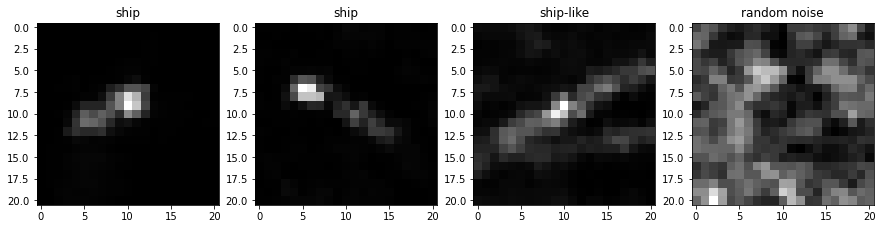

In [58]:
# visualize image samples 

plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1,4, figsize=(15, 15)) 

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0].imshow(ship_positive_data[1200,:,:], cmap="gray")
axarr[0].set_title('ship')
axarr[1].imshow(ship_positive_data[14,:,:], cmap="gray")  
axarr[1].set_title('ship')
axarr[2].imshow(false_positives_data[43,:,:], cmap="gray")
axarr[2].set_title('ship-like')
axarr[3].imshow(true_negatives_data[121,:,:], cmap="gray") 
axarr[3].set_title('random noise')

### Resized (80x80) 

Text(0.5, 1.0, 'random noise')

<Figure size 432x288 with 0 Axes>

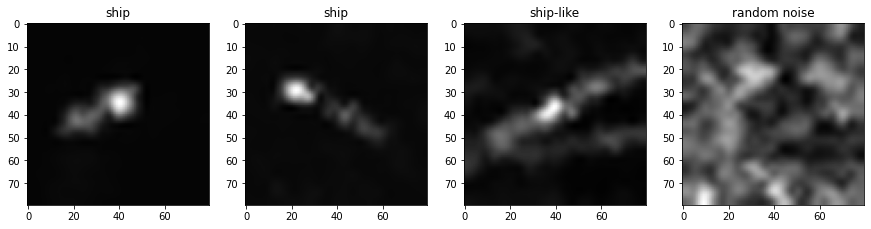

In [59]:
# visualize image samples 

plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1,4, figsize=(15, 15)) 

# use the created array to output your multiple images.
axarr[0].imshow(ship_positive_80[1200,:,:], cmap="gray")
axarr[0].set_title('ship')
axarr[1].imshow(ship_positive_80[14,:,:], cmap="gray")  
axarr[1].set_title('ship')
axarr[2].imshow(false_positives_80[43,:,:], cmap="gray")
axarr[2].set_title('ship-like')
axarr[3].imshow(true_negatives_80[121,:,:], cmap="gray") 
axarr[3].set_title('random noise')

In [64]:
# combining all the classes into one array
radar_data = np.concatenate([ship_positive_80, false_positives_80, true_negatives_80])
angle_data = np.concatenate([ship_positive_angle, false_positives_angle, true_negatives_angle])
target = np.concatenate([ship_positive_target, false_positives_target, true_negatives_target])

In [65]:
# combining 2 band into one array
data = np.concatenate([radar_data[:, :, :, np.newaxis], angle_data[:, :, :, np.newaxis]], axis=-1)

In [66]:
# 0 - true negative
# 1 - true positive
# 2 - false positive
class_label = {
    0: 'random noise',
    1: 'ship-like',
    2: 'ship'
}

# give class labes to the target values
labeled_target = np.vectorize(class_label.get)(target)

pd.DataFrame([dict(Counter(labeled_target))])

,ship,ship-like,random noise
0,1596,1596,1596


In [97]:

# Define the data split strategy
def data_split(data, target, train_size, test_size): 
    ''' Train-validation-test split'''

    # split data to get the initial training test split
    X_train, X_test, y_train, y_test = train_test_split(data, target, random_state=1, 
                                                train_size=train_size, stratify = target)
    
    # split data to get train validation split
    X_train_cv, X_valid, y_train_cv, y_valid = train_test_split( X_train, y_train, random_state=1,
                                                test_size = valid_size, stratify = y_train) 
    
    return  X_train_cv, X_valid, X_test, y_train_cv, y_valid, y_test

# define split parameters
train_size = 0.75
valid_size = 0.20

X_train_cv, X_valid, X_test, y_train_cv, y_valid, y_test = data_split(data, target, train_size, valid_size )
print(f'data split: \nTrain: \t    {X_train_cv.shape[0]} \nValidation: {X_valid.shape[0]} \nTest: \t    {X_test.shape[0]}')

data split: 
Train: 	    2872 
Validation: 719 
Test: 	    1197


## Buiding the Model

In [79]:
#Import Keras.
from matplotlib import pyplot
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D,UpSampling2D, Dense, Dropout, Input, Flatten, Activation
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras import initializers
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.metrics import binary_accuracy
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
#import tensorflow_adons as tfa

In [110]:
# Deschesne ship detection model
def deschesne_model():
    model = Sequential()
    
    # conv block 1
    model.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='same', input_shape=(80,80,2)))
    model.add(Conv2D(256, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2,2))) # does this make 80x80 => 40x40 ?
    model.add(Dropout(0.1))
    
    # conv block 2
    model.add(Conv2D(256, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(Conv2D(512, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2,2))) # image size: 80x80 => 40x40
    model.add(Dropout(0.1))
              
    # conv block 3
    model.add(Conv2D(512, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(Conv2D(512, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
    
    #Flatten the data for upcoming dense layers
    model.add(Flatten())
    
    # fully connected block 1
    model.add(Dense(64))
    model.add(UpSampling2D(size=(2,2)))
    model.add(Dropout(0.1))
              
    # conv block 4
    model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(UpSampling2D(size=(2,2)))
    model.add(Dropout(0.1))
              
    # output Layer
    #model.add(Dense(3))                                       # set 3 classes for the last output layer
    model.add(Conv2D(3, kernel_size=(3,3), activation='softmax'))   # set 'softmax' as activation for multiclass classif
    
    # compile model
    #mypotim = SGD(lr=0.01, momentum=0.9)
    mypotim=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    #mypotim = RMSprop(lr=0.001)
    model.compile(loss='sparse_categorical_crossentropy',  
                  optimizer=mypotim,
                  metrics=['accuracy'])                     
    model.summary()
    return model


def get_callbacks(filepath, patience=2):
    es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]

# save the best weights
file_path = ".model_weights_Deschesne_balanced_ds.hdf5"
callbacks = get_callbacks(filepath=file_path, patience=10) # increased the "patience"

In [111]:

#Without denoising, core features.
gmodel=deschesne_model()
gmodel.fit(X_train_cv, y_train_cv,
          batch_size=24,
          epochs=50,
          verbose=1,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

ValueError: Shape must be rank 4 but is rank 2 for 'up_sampling2d_16/ResizeNearestNeighbor' (op: 'ResizeNearestNeighbor') with input shapes: [?,64], [2].

In [ ]:

# model validation evaluation
gmodel.load_weights(weigth_path)
score = gmodel.evaluate(X_valid, y_valid, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
# model test evaluation
score = gmodel.evaluate(X_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
y_pred = gmodel.predict(X_test, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
labels = np.array(['random noise 0', 'ship-like 1', 'ship 2'])

print()
print(classification_report(y_test, y_pred_bool, target_names=labels))
print('Confusion matrix \n', confusion_matrix(y_test, y_pred_bool))

In [ ]:
# get the indexes of the images being wrongly classified
#incorrects = np.argwhere(y_pred_bool != y_test)
incorrects = np.nonzero(y_pred_bool != y_test)[0]
incorrects

In [ ]:
# visualize image samples 

plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1,4, figsize=(15, 15)) 

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0].imshow(ship_positive_75[3,:,:], cmap="gray")
axarr[0].set_title('ship')
axarr[1].imshow(ship_positive_75[54,:,:], cmap="gray")  
axarr[1].set_title('ship')
axarr[2].imshow(ship_positive_75[86,:,:], cmap="gray")
axarr[2].set_title('ship-like')
axarr[3].imshow(ship_positive_75[1119,:,:], cmap="gray") 
axarr[3].set_title('random noise')